## Project Structure
```
2DIP_exercise/
│-- data/             # Contains images & videos
│   │-- input/        # 1 image and 1 video for each phase respectively
│   │-- output/       # All output images/videos must be stored here
│-- notebooks/        # Jupyter Notebooks for each phase
│   │-- part1.ipynb   # Image processing & feature extraction
│   │-- part2.ipynb   # Optical flow, object detection and tracking 
│-- README.md         # Project instructions
```

In [1]:
# imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define paths
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
inputs = os.path.join(base_path, 'data','input')
outputs = os.path.join(base_path, 'data','output')

## Supplementary Code for Visualization

In [3]:
def display_images(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


## Task 1 : Use image features to detect traffic signs in street images. **(7)**

a) Identify the type of noise and denoise the images. Use these denoised images for the next tasks. **(1)**

In [4]:
def denoise(input_path, output_path):
    img = cv2.imread(input_path)
    denoised = cv2.medianBlur(img, ksize=3)
    cv2.imwrite(output_path, denoised)
    return denoised

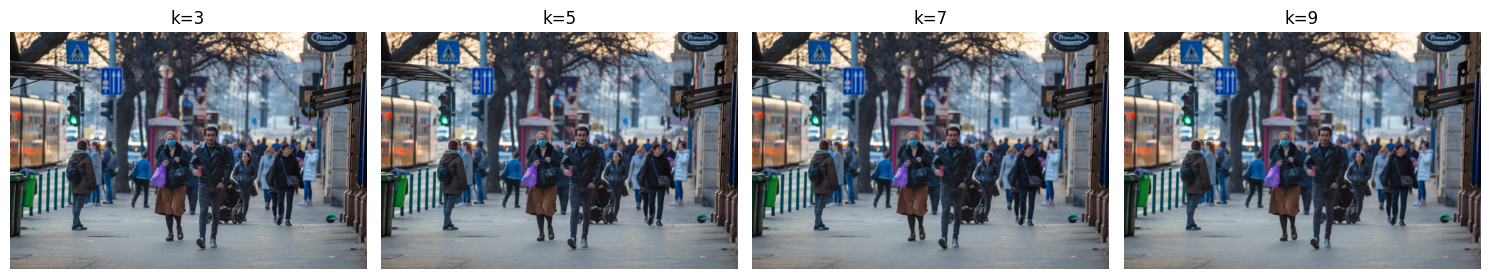

In [5]:
def test_kernel_sizes(input_path, output_dir, kernel_sizes):
    img = cv2.imread(input_path)
    results = []

    for k in kernel_sizes:
        denoised = cv2.medianBlur(img, ksize=k)
        out_path = os.path.join(output_dir, f'denoised_k{k}.jpg')
        cv2.imwrite(out_path, denoised)
        results.append((k, denoised))

    # Display results
    plt.figure(figsize=(15, 5))
    for i, (k, result_img) in enumerate(results):
        img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(kernel_sizes), i + 1)
        plt.imshow(img_rgb)
        plt.title(f'k={k}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
input_path = os.path.join(inputs, 'part1.jpg')
test_kernel_sizes(input_path, outputs, kernel_sizes=[3, 5, 7, 9])

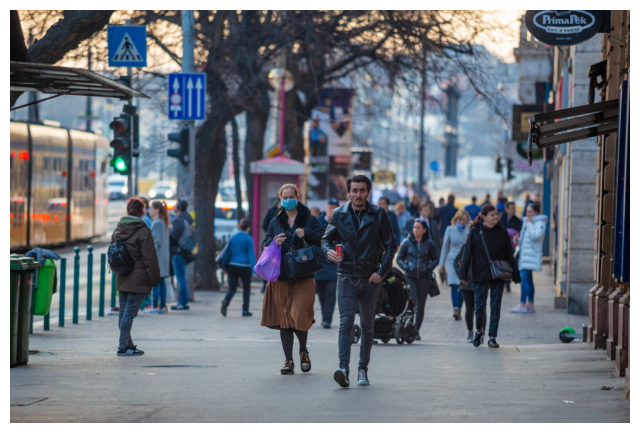

In [6]:
image_path = os.path.join(inputs, 'part1.jpg')
output_path = os.path.join(outputs, 'denoised_image.jpg')

image = denoise(image_path, output_path)
display_images(image)

b) Detect regions corresponding to traffic signs. **(3)**

In [7]:
def segment_traffic_signs(image_path, output_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(image, image, mask=mask)
    cv2.imwrite(output_path, result)
    return result


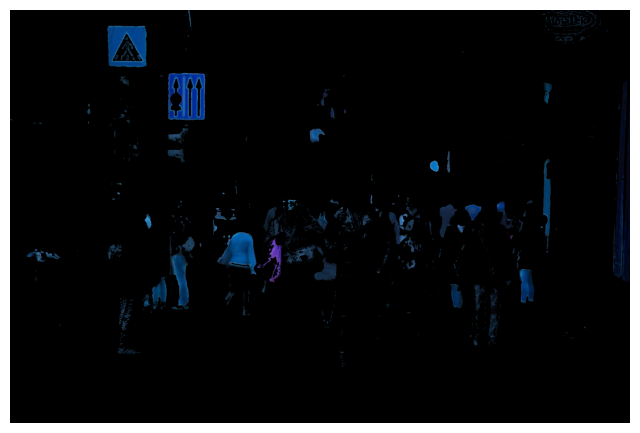

In [8]:
image_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'color_segmented_image.jpg')

image = segment_traffic_signs(image_path, output_path)
display_images(image)

c) Refine detected region boundaries with appropriate methods. **(3)**

In [9]:
def refine_traffic_signs(image_path, output_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.0)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    edge_mask = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    refined = cv2.bitwise_and(image, edge_mask)
    cv2.imwrite(output_path, refined)
    return refined

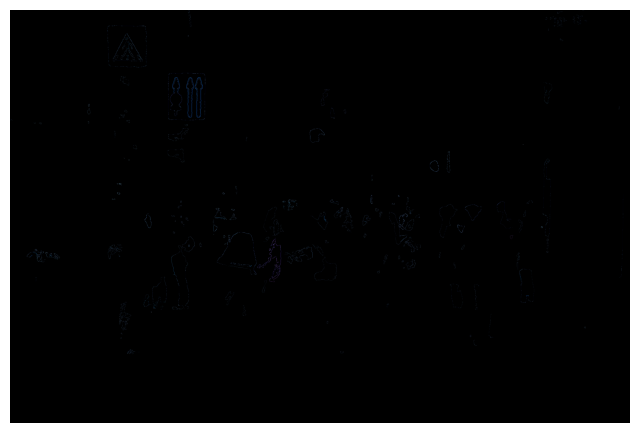

In [10]:
image_path = os.path.join(outputs, 'color_segmented_image.jpg')
output_path = os.path.join(outputs, 'refined_traffic_signs.jpg')

image = refine_traffic_signs(image_path, output_path)
display_images(image)

## Task 2 : Feature extraction and detection of pedestrians. **(8)**

a) Use an appropriate alogorithm to detect pedestrians. Draw bounding boxes around the detected pedestrians. **(3)**

In [11]:
def detect_pedestrians(image_path, output_path):
    import cv2

    image = cv2.imread(image_path)
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    boxes, weights = hog.detectMultiScale(image, winStride=(8, 8))

    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(output_path, image)
    return image

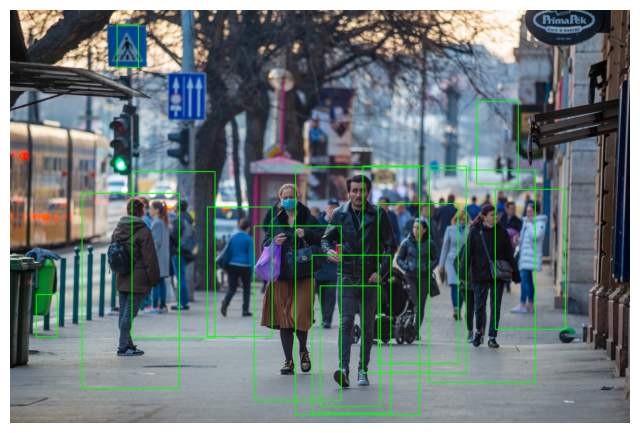

In [12]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'pedestrians.jpg')

image = detect_pedestrians(input_path, output_path)
display_images(image)

b) Detect faces of pedestrian and draw a bounding box around detected faces. **(3)**

In [13]:
def detect_faces(input_path, output_path):
    from math import atan2, cos, sin, sqrt, pi

    def draw_axis(img, p, q, color, scale=1):
        angle = atan2(p[1] - q[1], p[0] - q[0])
        hypotenuse = sqrt((p[0] - q[0]) ** 2 + (p[1] - q[1]) ** 2)
        q = (int(p[0] - scale * hypotenuse * cos(angle)),
             int(p[1] - scale * hypotenuse * sin(angle)))
        cv2.line(img, p, q, color, 1, cv2.LINE_AA)
        hook_len = 9
        hook1 = (int(q[0] + hook_len * cos(angle + pi / 4)), int(q[1] + hook_len * sin(angle + pi / 4)))
        hook2 = (int(q[0] + hook_len * cos(angle - pi / 4)), int(q[1] + hook_len * sin(angle - pi / 4)))
        cv2.line(img, hook1, q, color, 1, cv2.LINE_AA)
        cv2.line(img, hook2, q, color, 1, cv2.LINE_AA)

    def pca_orientation(gray_face, image, face_rect):
        _, binary = cv2.threshold(gray_face, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        for cnt in contours:
            if cv2.contourArea(cnt) < 100:  # ignore tiny contours
                continue
            data_pts = np.reshape(cnt, (-1, 2)).astype(np.float64)
            mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean=None)
            center = tuple((np.array(face_rect[:2]) + mean[0]).astype(int))
            p1 = (int(center[0] + 0.02 * eigenvectors[0, 0] * eigenvalues[0, 0]),
                  int(center[1] + 0.02 * eigenvectors[0, 1] * eigenvalues[0, 0]))
            p2 = (int(center[0] - 0.02 * eigenvectors[1, 0] * eigenvalues[1, 0]),
                  int(center[1] - 0.02 * eigenvectors[1, 1] * eigenvalues[1, 0]))
            draw_axis(image, center, p1, (0, 255, 0))
            draw_axis(image, center, p2, (255, 255, 0))
            break

    image = cv2.imread(input_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(cascade_path)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6, minSize=(30, 30))

    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)

        face_roi = gray[y:y + h, x:x + w]
        pca_orientation(face_roi, image, (x, y, w, h))

    cv2.imwrite(output_path, image)
    return image

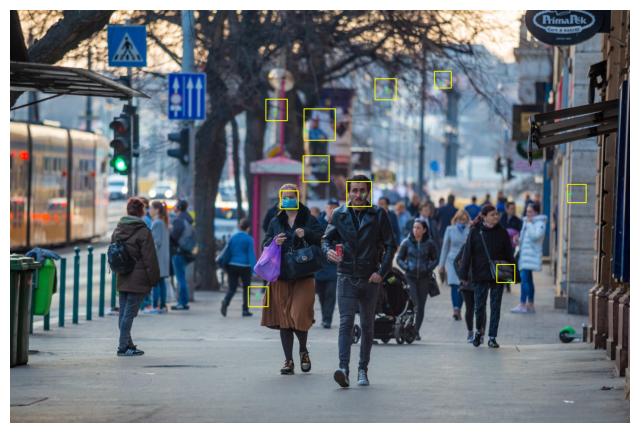

In [14]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'faces.jpg')

image = detect_faces(input_path, output_path)
display_images(image)

c) Briefly discuss the methods used for the above tasks. **(2)**

In [ ]:
#TODO c):